# Exercise - Unconstrained Optimization

## Data

All the analysis below applies to the data set,
* `data/spx_weekly_returns.xlsx`
* The file has **weekly** returns.
* For annualization, use 52 periods per year.

Consider only the following 10 stocks...

In [1]:
import polars as pl
import numpy as np
from pathlib import Path
from typing import List, Literal
from sklearn.linear_model import LinearRegression
import altair as alt
import matplotlib.pyplot as plt
import sys
sys.path.append(str(Path.cwd().parents[1] / "src"))
from finm367.utils import print_sheetname, concat_with_labels, only_numeric
from finm367.metrics import calc_moment, calc_max_dd, calc_cov
from finm367.plot_tools import plot_corr, plot_bar

DATA_PATH = Path.cwd().parents[1] / "data"
FILE_PATH = DATA_PATH / "spx_returns_weekly.xlsx"
FREQ = 52

In [2]:
print_sheetname(FILE_PATH)

['s&p500 names', 'benchmark names', 's&p500 rets', 'benchmark rets']

In [3]:
TICKS =  ['AAPL','NVDA','MSFT','GOOGL','AMZN','META','TSLA','AVGO','BRK/B','LLY']

As well as the ETF,

In [4]:
TICK_ETF = 'SPY'

### Data Processing

In [5]:
import pandas as pd
import polars as pl

In [6]:
SHEET_INFO = 's&p500 names'
SHEET_RETURNS = 's&p500 rets'
SHEET_BENCH = 'benchmark rets'

FREQ = 52

In [7]:
info = pd.read_excel(FILE_PATH,sheet_name=SHEET_INFO)
info.set_index('ticker',inplace=True)
info.loc[TICKS]

,name,mkt cap
ticker,,
AAPL,Apple Inc,3.008822e+12
NVDA,NVIDIA Corp,3.480172e+12
MSFT,Microsoft Corp,3.513735e+12
GOOGL,Alphabet Inc,2.145918e+12
AMZN,Amazon.com Inc,2.303536e+12
META,Meta Platforms Inc,1.745094e+12
TSLA,Tesla Inc,9.939227e+11
AVGO,Broadcom Inc,1.148592e+12
BRK/B,Berkshire Hathaway Inc,1.064240e+12


In [8]:
rets = pd.read_excel(FILE_PATH,sheet_name=SHEET_RETURNS)
rets.set_index('date',inplace=True)
rets = rets[TICKS]

In [9]:
bench = pd.read_excel(FILE_PATH,sheet_name=SHEET_BENCH)
bench.set_index('date',inplace=True)
rets[TICK_ETF] = bench[TICK_ETF]

In [10]:
# turn pandas df into polars
rets = pl.DataFrame(rets.reset_index()).with_columns(pl.col("date").cast(pl.Date))
rets.head()

date,AAPL,NVDA,MSFT,GOOGL,AMZN,META,TSLA,AVGO,BRK/B,LLY,SPY
date,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
2015-01-09,0.024514,-0.009315,0.009195,-0.054445,-0.037534,-0.009055,-0.057685,0.047971,0.002011,-0.001855,-0.005744
2015-01-16,-0.053745,0.000836,-0.020131,0.019448,-0.02088,-0.032931,-0.06576,-0.010268,-0.001739,0.010726,-0.012827
2015-01-23,0.06595,0.037578,0.020329,0.061685,0.074431,0.035255,0.042575,0.0305,-0.000603,0.020514,0.016565
2015-01-30,0.036997,-0.072636,-0.143706,-0.00813,0.1349,-0.024669,0.011476,-0.038331,-0.034938,-0.001802,-0.026931
2015-02-06,0.019114,0.062269,0.049753,-0.006812,0.055737,-0.018967,0.067589,0.018037,0.043569,-0.022778,0.030584


***

# 1. Risk Statistics

### 1.1.

Display a table with the following metrics for each of the return series.

* mean (annualized)
* volatility (annualized)
* Sharpe ratio (annualized)
* skewness
* kurtosis
* maximum drawdown

#### Note
We  have total returns, and Sharpe ratio is technically defined for excess returns. Don't worry about the difference. (Or subtract `SHV` if you prefer.)

In [11]:
TICKS = rets.columns[1:]
mu = rets[TICKS].mean() * FREQ
vol = rets[TICKS].std() * np.sqrt(FREQ)
sharpe = mu / vol
skewness = calc_moment(rets, m=3)
kurtosis = calc_moment(rets, m=4) - 3   # excess
max_dd_list = []
for tick in TICKS:
    max_dd = calc_max_dd(rets, tick, date_col="date")["max_drawdown"]
    max_dd_list.append(max_dd)
max_dd = pl.DataFrame({
    col: val for col, val in zip(TICKS, max_dd_list)
})

In [12]:
result = concat_with_labels({
    "mean": mu, "volatility": vol, "sharpe": sharpe, "skewness": skewness, "kurtosis": kurtosis, "max_drawdown": max_dd
})

In [13]:
result

statistic,AAPL,NVDA,MSFT,GOOGL,AMZN,META,TSLA,AVGO,BRK/B,LLY,SPY
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""mean""",0.238714,0.64558,0.261402,0.2168,0.293447,0.261924,0.469754,0.394854,0.135025,0.281542,0.131264
"""volatility""",0.276629,0.463283,0.23998,0.279851,0.306,0.351336,0.586431,0.375132,0.190654,0.28298,0.170877
"""sharpe""",0.862938,1.39349,1.089266,0.774698,0.958976,0.745509,0.801039,1.052574,0.708223,0.994919,0.768182
"""skewness""",-0.217776,0.343469,0.071882,0.580765,0.063055,0.052232,0.545512,0.659669,-0.200114,0.215223,-0.576676
"""kurtosis""",1.789172,1.357184,2.299157,3.663137,1.745295,3.962588,1.560033,3.448352,2.468885,1.648058,5.913492
"""max_drawdown""",-0.346408,-0.659362,-0.350539,-0.41864,-0.548307,-0.760252,-0.722459,-0.400357,-0.26477,-0.252524,-0.318291


### 1.2.

As a standalone investment, which is most attractive? And least? Justify your answer.

### 1.3.

For each investment, estimate a regression against `SPY`. Report the 
* alpha (annualized as a mean)
* beta
* info ratio
* r-squared

Based on this table, which investment seems most attractive relative to holding `SPY`?

In [14]:
def calc_regression_metrics(
    data: pl.DataFrame,
    X: str | List[str],
    y: str,
    metrics: List[str] | Literal["all"] = "all",
    freq: int = 52
) -> pl.DataFrame:
    """
    Calculate regression metrics for y regressed on X.
    
    For single X (bivariate): returns alpha, beta, info_ratio, r_squared
    For multiple X (multivariate): returns betas only (no alpha, IR, R²)
    
    Parameters
    ----------
    data : pl.DataFrame
        DataFrame containing return data
    X : str or List[str]
        Independent variable(s) - column name(s) for predictor(s)
    y : str
        Dependent variable - column name for outcome
    metrics : List[str] or "all", default "all"
        Metrics to calculate. Options: ["alpha", "beta", "info_ratio", "r_squared"]
        Use "all" for all metrics (only works with single X)
    freq : int, default 52
        Number of periods per year for annualization (52 for weekly, 252 for daily)
    
    Returns
    -------
    pl.DataFrame
        DataFrame with requested regression metrics
        - For single X: one row with all metrics
        - For multiple X: one row per X variable with beta values
    """
    data = data.select(pl.col(pl.Float64))

    # Extract y data
    y_data = data.select(pl.col(y)).to_numpy().reshape(-1, 1)
    y_name = y
    
    # Handle single vs multiple X
    is_multivariate = isinstance(X, list) and len(X) > 1
    
    if isinstance(X, str):
        # Single X (bivariate regression)
        X_data = data.select(pl.col(X)).to_numpy().reshape(-1, 1)
        X_names = [X]
    elif isinstance(X, list):
        # Multiple X
        X_data = data.select(X).to_numpy()
        X_names = X
    else:
        raise TypeError(f"X must be str or List[str], got {type(X)}")
    
    # Fit regression
    model = LinearRegression().fit(X_data, y_data)
    
    # Get coefficients
    if X_data.shape[1] == 1:    # bivariate
        betas = [model.coef_[0][0]]
    else:
        betas = model.coef_[0].tolist()
    
    # For multivariate, only return betas
    if is_multivariate:
        result_df = pl.DataFrame({
            "Ticker": X_names,
            f"Beta_{y}": betas
        })
        return result_df
    
    # For bivariate, calculate all requested metrics
    result_dict = {}
    
    # Determine which metrics to calculate
    if metrics == "all":
        metrics_to_calc = ["alpha", "beta", "info_ratio", "r_squared"]
    else:
        metrics_to_calc = metrics
    
    # Calculate beta (always needed)
    beta = betas[0]
    
    if "beta" in metrics_to_calc:
        result_dict["beta"] = beta
    
    if any(m in metrics_to_calc for m in ["alpha", "info_ratio", "r_squared"]):
        # Get predictions and residuals
        y_pred = model.predict(X_data)
        residuals = y_data - y_pred
        
        # Alpha
        alpha_per_period = model.intercept_[0]
        alpha_annualized = alpha_per_period * freq
        
        if "alpha" in metrics_to_calc:
            result_dict["alpha"] = alpha_annualized
        
        # Information ratio
        if "info_ratio" in metrics_to_calc:
            residual_std = np.std(residuals, ddof=1)
            if residual_std:
                info_ratio = alpha_annualized / (residual_std * np.sqrt(freq))
            else:
                info_ratio = None
            result_dict["info_ratio"] = info_ratio
        
        # R-squared
        if "r_squared" in metrics_to_calc:
            y_mean = np.mean(y_data)
            ss_tot = np.sum((y_data - y_mean) ** 2)
            ss_res = np.sum(residuals ** 2)
            r_squared = 1 - (ss_res / ss_tot)
            result_dict["r_squared"] = r_squared
    
    # Add ticker name
    result_dict = {"X": X_names[0], "y": y_name, **result_dict}
    
    # Create single-row DataFrame
    result_df = pl.DataFrame([result_dict])
    
    return result_df


def calc_regression_metrics_batch(
    data: pl.DataFrame,
    X: str,
    y_cols: List[str],
    metrics: List[str] | Literal["all"] = "all",
    periods_per_year: int = 52
) -> pl.DataFrame:
    """
    Calculate regression metrics for multiple y variables against a single X.
    Useful for analyzing multiple assets against a benchmark.
    
    Parameters
    ----------
    data : pl.DataFrame
        DataFrame containing return data
    X : str
        Independent variable - column name for predictor (e.g., "SPY")
    y_cols : List[str]
        List of dependent variables - column names for outcomes (e.g., ["AAPL", "NVDA"])
    metrics : List[str] or "all", default "all"
        Metrics to calculate. Options: ["alpha", "beta", "info_ratio", "r_squared"]
    periods_per_year : int, default 52
        Number of periods per year for annualization
    
    Returns
    -------
    pl.DataFrame
        DataFrame with one row per y variable, containing all requested metrics
    """
    results = []
    
    for y_col in y_cols:
        result = calc_regression_metrics(
            data=data,
            X=X,
            y=y_col,
            metrics=metrics,
            freq=periods_per_year
        )
        results.append(result)
    
    # Concatenate all results
    final_df = pl.concat(results, how="vertical")
    
    return final_df

In [15]:
calc_regression_metrics_batch(
    rets, "SPY", TICKS, "all", FREQ
)

X,y,beta,alpha,info_ratio,r_squared
str,str,f64,f64,f64,f64
"""SPY""","""AAPL""",1.113225,0.092587,0.460988,0.472864
"""SPY""","""NVDA""",1.735395,0.417785,1.173737,0.409703
"""SPY""","""MSFT""",1.031545,0.125997,0.773696,0.539501
"""SPY""","""GOOGL""",1.066242,0.07684,0.361742,0.423861
"""SPY""","""AMZN""",1.06629,0.153481,0.624309,0.354546
…,…,…,…,…,…
"""SPY""","""TSLA""",1.762157,0.238446,0.473837,0.263646
"""SPY""","""AVGO""",1.357018,0.216726,0.734963,0.382092
"""SPY""","""BRK/B""",0.817041,0.027777,0.213941,0.536244


***

# 2. Portfolio Allocation

### 2.1.

Display the correlation matrix of the returns.

* Based on this information, which investment do you anticipate will get extra weight in the portfolio, beyond what it would merit for its mean return?

* Report the maximally correlated assets and the minimally correlated assets.

In [16]:
rets_corr = rets.select(pl.col(pl.Float64)).corr()

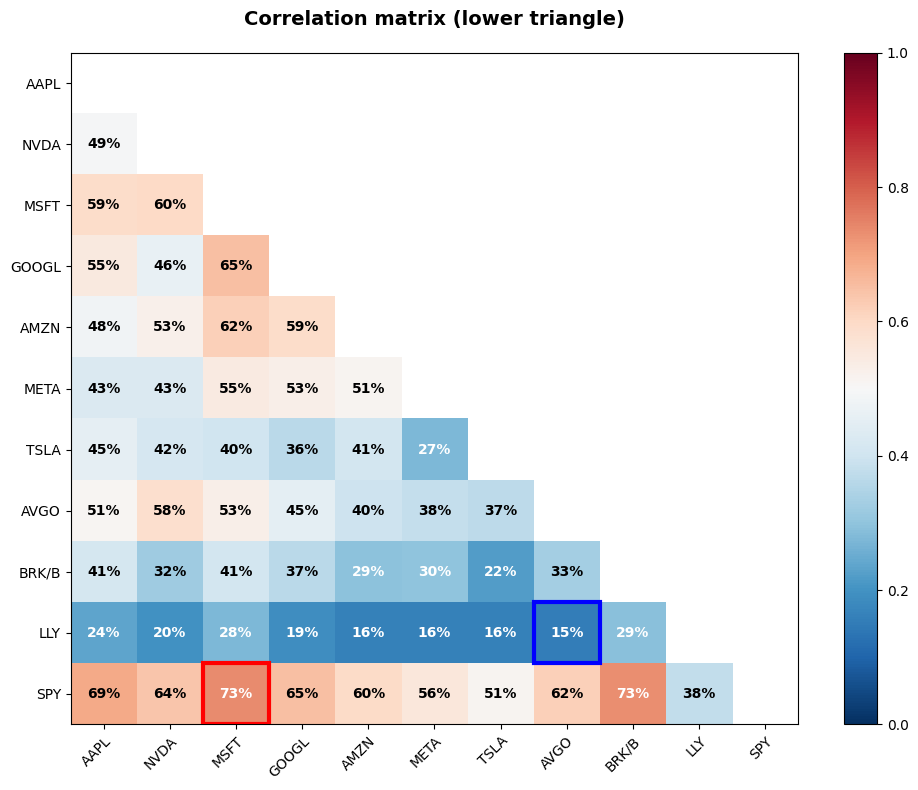

In [17]:
fig, ax = plot_corr(rets_corr, labels=TICKS)
plt.show()

### 2.2.

Calculate the weights of the mean-variance optimized portfolio, also called the tangency portfolio.

* Display a table indexed by each investment, with the optimal weights in one column and the Sharpe ratios in another column.

* Do the investments with the best Sharpe ratios tend to get the biggest weights?

#### Note:
To estimate the optimal weights, consider using the provided function below.

In [22]:
def optim_weights(
    returns: pl.DataFrame,
    dropna: bool=True,
    scale_cov: int=1,
    type: str="uncon"
) -> pl.DataFrame:
    """
    Mean-variance optimization for weights

    Parameters
    -----------
    returns : asset return dataframe
    dropna : bool
    scale_cov : all solutions are just rescaling of one
    type : "uncon" or "con"
    """
    returns = only_numeric(returns)
    if dropna:
        returns = returns.drop_nulls()

    covmat_full = calc_cov(returns)
    covmat_diag = np.diag(np.diag(covmat_full))
    covmat = scale_cov * covmat_full.to_numpy() + (1 - scale_cov) * covmat_diag

    weights = np.linalg.solve(covmat, returns.mean().to_numpy().reshape(-1, 1))
    weights = weights / weights.sum()

    if returns.mean() @ weights < 0:
        weights = -weights

    return pl.DataFrame({
        col: weights[i] for i, col in enumerate(returns.columns)
    })

In [23]:
w_optim = optim_weights(rets)

In [24]:
w_optim

AAPL,NVDA,MSFT,GOOGL,AMZN,META,TSLA,AVGO,BRK/B,LLY,SPY
f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
0.409367,0.882896,0.848584,0.193126,0.426356,0.277408,0.31015,0.601896,2.580474,1.11263,-6.642887


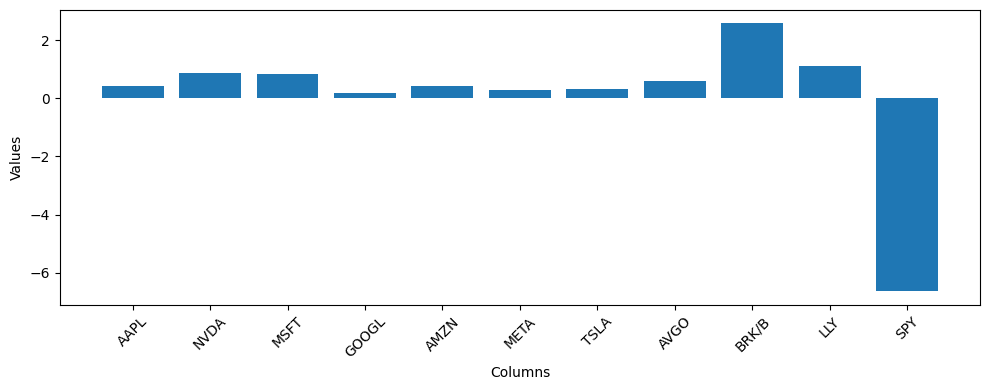

In [25]:
plot_bar(w_optim)

### 2.3.

Report the following performance statistics of the portfolio achieved with the optimized weights calculated above.
* mean
* volatility
* Sharpe

(Annualize all three statistics.)

### 2.4.

Try dropping the asset which had the biggest short position from the investment set. Re-run the optimization. What do you think of these new weights compared to the original optimized weights?

What is going on?

****